### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm

### Envs

In [2]:
train_path = 'io/input/data_raw/train.csv'
assets_details_path ='io/input/data_raw/asset_details.csv'
train_obj_path = 'io/input/data_intermidiate/train_object.pkl'

### Core Functionality

In [3]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [4]:
def load_data(train_path, assets_details_path):
    trainset = pd.read_csv(train_path,index_col=0)
    assets_details = pd.read_csv(assets_details_path,index_col=0)
    trainset.reset_index(inplace=True)
    assets_details.reset_index(inplace=True)
    trainset = pd.merge(trainset, assets_details[['Asset_ID', 'Weight', 'Asset_Name']],
                         on='Asset_ID', how='inner', left_index=False)
    trainset = reduce_mem_usage(trainset)
    trainset['timestamp'] = pd.to_datetime(trainset['timestamp'], unit='s')
    trainset = trainset.drop(['Asset_ID'], axis=1)
    trainset['Target'].fillna(trainset['Target'].median(), inplace=True)
    return trainset

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
                    
    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    return df

### Data Analysis

In [6]:
def describe_df(df):
    print(f'Shape: {df.shape}')  
    print(f'\nColumn Names: {df.columns}')  
    print(f'\nData Types:')
    print(df.dtypes) 
    print(f'\nNon-Missing Values:')
    print(df.count()) 
    print(f'\nMissing Values:')
    print(df.isnull().sum()) 
    print(f'\nDistinct Values:')
    print(df.nunique())  
    print(f'\nSummary Statistics:')
    print(df.describe())
    return True

In [7]:
def plot_assets_ts(df):
    df["Asset_Name"] = df["Asset_Name"].astype("category")
    grouped = df.groupby(["Asset_Name", "timestamp"]).sum()
    sns.lineplot(x="timestamp", y="Target", hue="Asset_Name", data=df)
    plt.gcf().autofmt_xdate()
    n = 90 # number of days between each tick
    plt.title('Price by Asset')
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=n))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    plt.savefig('Exports/Analysis_Plots/Target_by_Asset.pdf')

In [11]:
def plot_assets_ts_weekly(df):
    # Create subplots
    fig, axes = plt.subplots(nrows=len(df['Asset_Name'].unique()), ncols=1, 
                             figsize=(10, 6*len(df['Asset_Name'].unique())))

    # Group data by asset and resample on weekly basis
    df_weekly = df.set_index('timestamp').groupby('Asset_Name').resample('W').sum().reset_index()
    # Plot the time series for each asset name
    for i, asset in enumerate(df['Asset_Name'].unique()):
        ax = axes[i]
        asset_df = df_weekly[df_weekly['Asset_Name'] == asset]
        ax.plot(asset_df['timestamp'], asset_df['Close'])
        ax.set_xlabel('Date')
        ax.set_ylabel('Close')
        ax.set_title(asset)

        # Format x-axis tick labels
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=200))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

    plt.tight_layout()
    plt.savefig('io/output/exports/analysis_plots/Target_by_Asset_Weekly.pdf')
    plt.show()

Memory usage of dataframe is 2403.86 MB
Memory usage after optimization is: 1132.59 MB
Decreased by 52.9%
Shape: (24236806, 11)

Column Names: Index(['timestamp', 'Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP',
       'Target', 'Weight', 'Asset_Name'],
      dtype='object')

Data Types:
timestamp     datetime64[ns]
Count                float32
Open                 float16
High                 float16
Low                  float16
Close                float16
Volume               float32
VWAP                 float64
Target               float16
Weight               float16
Asset_Name            object
dtype: object

Non-Missing Values:
timestamp     24236806
Count         24236806
Open          24236806
High          24236806
Low           24236806
Close         24236806
Volume        24236806
VWAP          24236797
Target        24236806
Weight        24236806
Asset_Name    24236806
dtype: int64

Missing Values:
timestamp     0
Count         0
Open          0
High          0


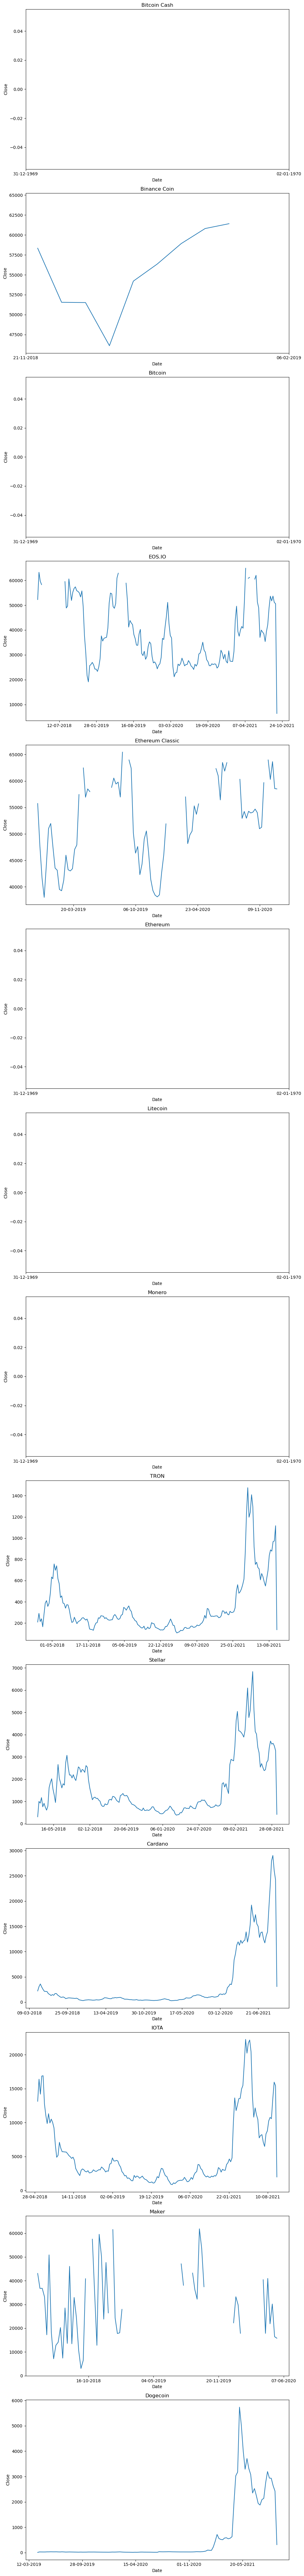

In [12]:
trainset=load_data(train_path, assets_details_path)
describe_df(trainset)
plot_assets_ts_weekly(trainset)
#plot_assets_ts(joined_df)

## Demo Code

In [ ]:
# def split_timestamps(df):
#     # Convert the 'timestamp' column to a pandas datetime object
#     df['timestamp'] = pd.to_datetime(df['timestamp'])

#     # Get a list of all unique asset IDs in the dataset
#     asset_ids = df['Asset_ID'].unique()

#     # Get a list of all features in the dataset
#     features = list(df.columns)
#     features.remove('timestamp')
#     features.remove('Asset_ID')

#     # Group the original DataFrame by the timestamp column
#     grouped = df.groupby('timestamp')

#     # Create an empty list to store the resulting DataFrames
#     result = []

#     # Loop through each unique timestamp using tqdm
#     for name, group in tqdm(grouped):
#         group.set_index('Asset_ID', inplace=True)
#         group = group.sort_index(ascending=True)
#         result.append(group)
#     return result

In [ ]:
trainset=load_data(train_path, assets_details_path)

In [ ]:
#describe_df(trainset)
#null_rows = joined_df[joined_df['Target'].isnull()]

In [ ]:
#plot_assets_ts_weekly(joined_df)
#plot_assets_ts(joined_df)

In [ ]:
trainset[21]